In [2]:
# imports
import nltk
nltk.download('stopwords')
import pandas as pd
from nltk.corpus import stopwords
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer 

import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#import dataset
data=pd.read_csv('/content/drive/My Drive/SL/tiago_final_2.csv')

# Preprocessing


In [ ]:
def  clean_text(df, text_field, new_text_field_name):
  df[new_text_field_name] = df[text_field].str.lower()
  df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
  # remove numbers
  df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
  
  return df

def word_pos_tagger(text):
    pos_tagged_text = nltk.pos_tag(text)
    return pos_tagged_text

# funzioni che :
#   la prima: pulisce il testo trasformandolo in una unica stringa senza caratteri speciali ne sequenze di escape
#   la seconda: prende il testo tokenizzato e lo "tagga"

In [ ]:
# data clean

data = clean_text(data, 'text', 'text_clean') # pulisce il testo come scritto sopra

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.append('\t')
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# rimuove le stopword

In [ ]:
nltk.download('punkt')
ps = PorterStemmer()
data['text_tokens'] = data['text_clean'].apply(lambda x: word_tokenize(x)) # tokenization
data['text_tokens'] = data['text_tokens'].apply(lambda x: [ps.stem(y) for y in x]) # stemmization

# tokenizza e fa stemming the testo

In [ ]:
nltk.download('averaged_perceptron_tagger')

data['text_tokens_pos_tagged'] = data['text_tokens'].apply(lambda x: word_pos_tagger(x))

# applica la funzione per "taggare"i vari tokens

In [ ]:
data.to_csv('/content/drive/My Drive/SL/FINAL_426_steamTokensPOS.csv', index=False)

DATA FOR THE MODEL 

In [3]:
data=pd.read_csv('/content/drive/My Drive/SL/FINAL_426_steamTokensPOS.csv')

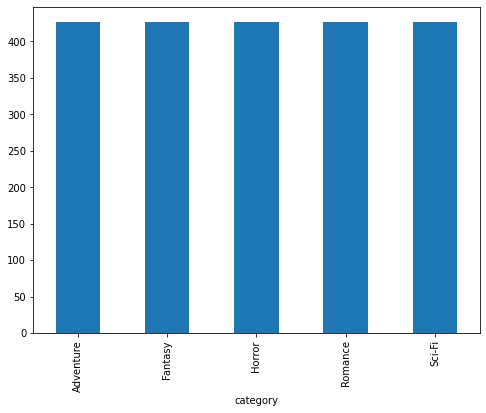

In [ ]:
df=data.copy()
fig = plt.figure(figsize=(8,6))
df.groupby('category').text_clean.count().plot.bar(ylim=0)
plt.show()

# verifichiamo che le varie categorie siano bilanciate

# We sart implementing some models in order to do a comparison between a normal learning and a deep learning

In [5]:
col = ['category', 'text_clean']
df = data[col]
df = df[pd.notnull(df['text_clean'])]

df.columns = ['category', 'text_clean']

df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()

# creazione della varibile category_id dove i nomi dei generi vengono trasformati in  numeri

,category,text_clean,category_id
0,Horror,tough crossposting ao im strawberryqueen since...,0
1,Horror,woman scorned woman scorned said holmes farm t...,0
2,Horror,thing puts creepy creepypasta virus spying coo...,0
3,Horror,torture smell rotting flesh burned nostrils bo...,0
4,Horror,cute little kitty sometimes used imagination f...,0


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.text_clean).toarray()
labels = df.category_id
features.shape

# creazione del tf_idf e conversione del dataset in un dataset numerico per l'elaborazione

(2130, 212276)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 4

d={}
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  d['uni_'+str(Product)]=unigrams[-N:]
  d['bi_'+str(Product)]=bigrams[-N:]

# indagine sugli unigram e bigram più "utili"/correlati all'interno di ogni genere

# We tried differents model: 

* random forest
*support vector machine classification ( linear and 'normal' version)
*naive bayes
*logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

#

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

 # The best one found was Linear-SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=0)
model = LinearSVC()
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'penalty': ['l1','l2'],
              'loss':['hinge','squared_hinge']}

randcv=RandomizedSearchCV(model, param_grid, refit = True)
randcv.fit(X_train, y_train) 
randcv.best_estimator_

In [ ]:
model = LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# implelemtazione della linear svc 

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'text_clean']])
      print('')


# print delle fanfiction classificate erroneamente

In [ ]:
model.score(X_test, y_test)

0.7425320056899004

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['category'].unique()))

# score per ogni genere

              precision    recall  f1-score   support

      Horror       0.76      0.86      0.81       141
   Adventure       0.74      0.60      0.66       141
      Sci-Fi       0.76      0.72      0.74       139
     Fantasy       0.68      0.70      0.69       137
     Romance       0.77      0.83      0.80       145

    accuracy                           0.74       703
   macro avg       0.74      0.74      0.74       703
weighted avg       0.74      0.74      0.74       703



SVM

In [ ]:
# Training Support Vector Machines - SVM and calculating its performance

from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42))])

text_clf_svm = text_clf_svm.fit(X_train, y_train)
predicted_svm = text_clf_svm.predict(X_test)
np.mean(predicted_svm == y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.4902597402597403

#Neural Network Implementation

FEED FORWARD NN

In [5]:
df=data.copy()
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix


from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import text, sequence
from keras import utils
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D

from sklearn.model_selection import train_test_split

train_size = int(len(df) * .7)
train_posts = df['text_clean'][:train_size]
train_tags = df['category'][:train_size]

test_posts = df['text_clean'][train_size:]
test_tags = df['category'][train_size:]

train_posts, test_posts, train_tags, test_tags= train_test_split(df['text_clean'], df.category, test_size=0.8, random_state=42)

max_words = 100000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = 5
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 128
epochs = 5  

# Build the model
#instatiate model
model = Sequential()

#this chunk is like the input layer
model.add(Dense(512, input_shape=(max_words,),use_bias=False)) # non consideriamo il bias dei dati
model.add(BatchNormalization()) # poichè facciamo questa standardizzazione: i pesi sono sulla stessa misura
model.add(Activation('tanh')) # la tan come acctivation viene meglio (???)
model.add(Dropout(0.25)) # eliminiamo alcuni neuroni nella rete per evitare overfitting peggiorando la norma (??)
# preprecessin ginterno dei dati al fine di essere pi gigeribile per la rete tolgiendone poi alcuni


#hidden layer
model.add(Dense(512, use_bias=False)) # ripetiamo quanto sopra, così che la rete invece di memoriazare, IMPARA :D
model.add(BatchNormalization())
model.add(Activation('tanh'))

model.add(Dropout(0.25))

#output layer
model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('softmax')) # la softmax ci aiuta meglio nella nostra classificazione per questo sta alla fine



# setting up the optimization of our weights 
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# il nostro ottimizzatore stocasting gradient che penalizza i pesi elevati per evitare overfitting ( come suggedeva nelle 
# versioni precendi) così che impari e non memorizzi solo


model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_split=0.2)

Train on 340 samples, validate on 86 samples
Epoch 1/5
 - 3s - loss: 0.4945 - accuracy: 0.8029 - val_loss: 1.1286 - val_accuracy: 0.6884
Epoch 2/5
 - 2s - loss: 0.2805 - accuracy: 0.8959 - val_loss: 0.8697 - val_accuracy: 0.6884
Epoch 3/5
 - 2s - loss: 0.2420 - accuracy: 0.9165 - val_loss: 0.5991 - val_accuracy: 0.7140
Epoch 4/5
 - 2s - loss: 0.2060 - accuracy: 0.9376 - val_loss: 0.4805 - val_accuracy: 0.7581
Epoch 5/5
 - 2s - loss: 0.1762 - accuracy: 0.9559 - val_loss: 0.4039 - val_accuracy: 0.8209


In [ ]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

# accuracy della rete neurale

1704/1704 [==============================] - 4s 2ms/step
Test accuracy: 0.8632628321647644


In [ ]:
y_pred=model.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

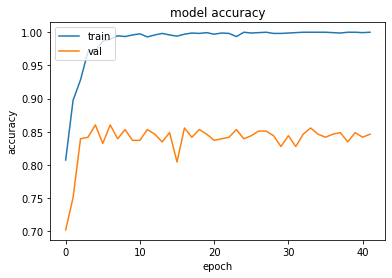

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

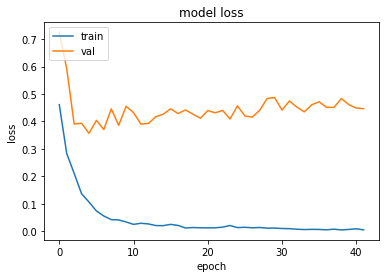

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

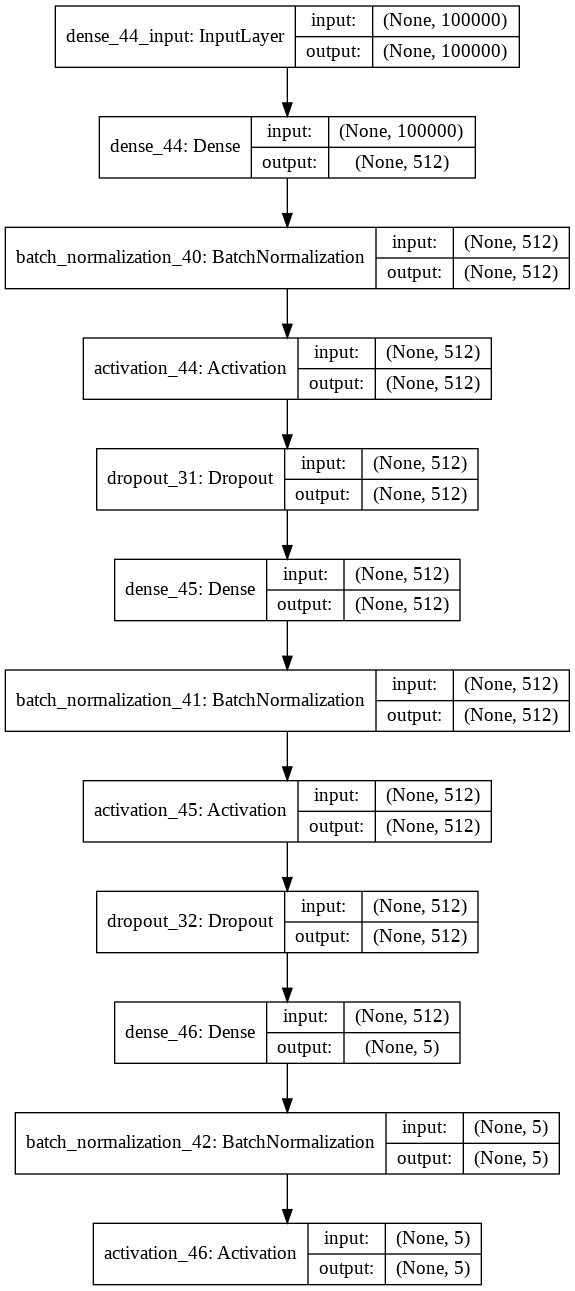

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='/content/drive/My Drive/SL/model_plot.png', show_shapes=True, show_layer_names=True)

ATTENTION NN

In [ ]:

"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open(os.path.join('/content/drive/My Drive/SL/crawl-300d-2M-subword.vec'),encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

# Search words in our word index in the pre-trained dataset
# Create an embedding matrix for our bbc dataset
min_wordCount = 0
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    try:
      if word_counts[word] > min_wordCount:
          embedding_vector = embeddings_index.get(word)
          
          if embedding_vector is not None:
              # words not found in embedding index will be all-zeros.
              embedding_matrix[i] = embedding_vector
          else:
              absent_words += 1
      else:
          small_words += 1
    except:
          continue
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')

Found 2000000 word vectors.
Total absent words are 17357 which is 23.21 % of total words
Words with 0 or less mentions 0 which is 0.00 % of total words


In [ ]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""

print(categoryToCode)
train, validation, test = split_df(data_cleaned, 'Code',0.8,0.1,0.1)

#Training
paras = []
for i in range(train['Text'].shape[0]):
    sequence = wordToSeq(train['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_train = np.array(paras)
y_train = to_categorical(train['Code'],categoryToCode)

#Validation
paras = []
for i in range(validation['Text'].shape[0]):
    sequence = wordToSeq(validation['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_val = np.array(paras)
y_val = to_categorical(validation['Code'],categoryToCode)

#Test
paras = []
for i in range(test['Text'].shape[0]):
    sequence = wordToSeq(test['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_test = np.array(paras)
y_test = to_categorical(test['Code'],categoryToCode)

{0: 'adventure', 1: 'fantasy', 2: 'horror', 3: 'romance', 4: 'scifi'}
Total:  1879
Training:  1503 , Percentage:  0.7998935604044705
Validation:  187 , Percentage:  0.09952102182011709
Test: 189 , Percentage:  0.10058541777541245


tracking <tf.Variable 'word_attention_9/W:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'word_attention_9/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'word_attention_9/u:0' shape=(100, 1) dtype=float32> u
tracking <tf.Variable 'sent_attention_8/W:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'sent_attention_8/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'sent_attention_8/u:0' shape=(100, 1) dtype=float32> u
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      (None, 50)                0         
_________________________________________________________________
word_embedding (Embedding)   (None, 50, 100)           7477800   
_________________________________________________________________
word_gru (Bidirectional)     (None, 50, 100)           45300     
__________________________________________________________

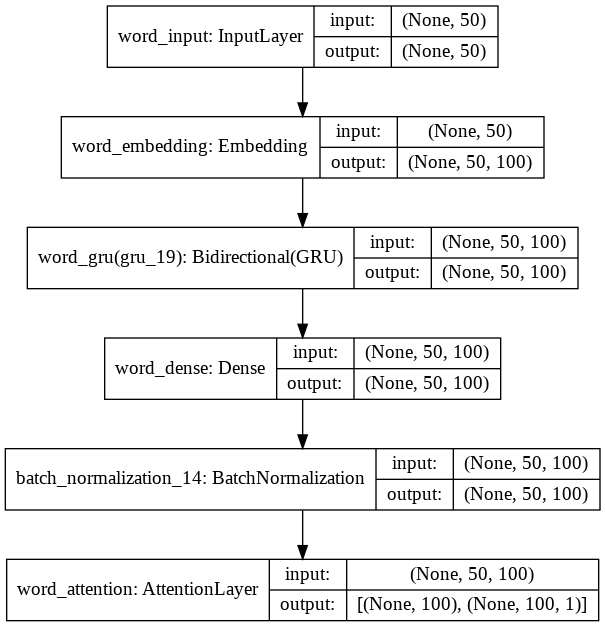

In [ ]:
pl

Train on 1503 samples, validate on 187 samples
Epoch 1/10
1503/1503 [==============================] - 73s 49ms/step - loss: 1.5895 - acc: 0.2508 - val_loss: 1.6075 - val_acc: 0.2299
Epoch 2/10
1503/1503 [==============================] - 69s 46ms/step - loss: 1.5765 - acc: 0.2735 - val_loss: 1.5990 - val_acc: 0.2299
Epoch 3/10
1503/1503 [==============================] - 70s 47ms/step - loss: 1.5774 - acc: 0.2774 - val_loss: 1.5912 - val_acc: 0.2299
Epoch 4/10
1503/1503 [==============================] - 70s 47ms/step - loss: 1.5651 - acc: 0.2774 - val_loss: 1.5720 - val_acc: 0.2781
Epoch 5/10
1503/1503 [==============================] - 70s 47ms/step - loss: 1.5635 - acc: 0.2735 - val_loss: 1.5698 - val_acc: 0.2781
Epoch 6/10
1503/1503 [==============================] - 70s 47ms/step - loss: 1.5656 - acc: 0.2774 - val_loss: 1.5630 - val_acc: 0.2781
Epoch 7/10
1503/1503 [==============================] - 69s 46ms/step - loss: 1.5667 - acc: 0.2528 - val_loss: 1.5611 - val_acc: 0.2781
E

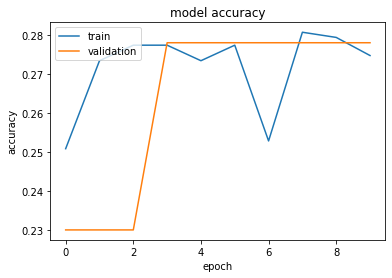

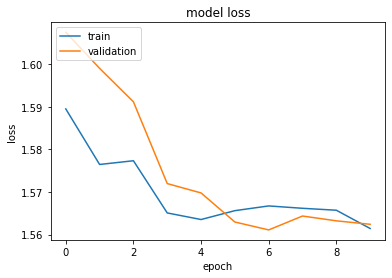

In [ ]:
#15 epoch invece che 7
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=100)

print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(x_test,y_test)
print("Test set accuracy: ",acc)
print("Test set loss: ", loss)

189/189 [==============================] - 2s 11ms/step
Test set accuracy:  0.28042328357696533
Test set loss:  1.5819111419102503


LSTM

In [13]:
from keras.models import Sequential
from keras.layers import Embedding,Conv1D,Dropout, Flatten,Dense
import tensorflow as tf
import pandas as pd
import numpy as np
from keras.applications.densenet import DenseNet201
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input,     decode_predictions
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam, SGD
from keras.layers.recurrent import LSTM
model = Sequential()
# Configuring the parameters
model.add(Embedding(74248, output_dim=50, input_length=100000))
model.add(LSTM(128, return_sequences=True))  
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100000, 50)        3712400   
_________________________________________________________________
lstm_5 (LSTM)                (None, 100000, 128)       91648     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100000, 128)       0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 3,853,781
Trainable params: 3,853,781
Non-trainable params: 0
____________________________________________

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy')
history = model.fit(x_train, y_train,
                    class_weight='balanced',
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 980 samples, validate on 109 samples
Epoch 1/5
980/980 [==============================] - 58s 59ms/step - loss: 0.4999 - val_loss: 0.4989
Epoch 2/5
896/980 [==========================>...] - ETA: 4s - loss: 0.4970

In [7]:
score = model.evaluate(x_test, y_test,
                       batch_size=32, verbose=1)
print('Test accuracy:', score[1])

# accuracy della rete neurale

1704/1704 [==============================] - 5s 3ms/step
Test accuracy: 0.4832655321677643
